# Conditional trajectory propagation and `TrajectoryFunctionWrappers`
This notebook shows how to propagte trajectories until certain conditions are met, e.g. a state is reached. It uses the `GmxEngine` to produce the trajectories and it will therefore only work if the gromacs executables are available (e.g. in your `$PATH` variable). It assumes some familiarity with the `GmxEngine` class, it is therfore recommended to finish the `gromacs/GmxEngine.ipynb` notebook first.

The two main classes you will use together:
 - `asyncmd.trajectory.PyTrajectoryFunctionWrapper`, a wrapper around any python function which can be applied to `asyncmd.Trajectory` objects. The wrapped function is turned into an asyncronously callable subprocess and the results are cached for each trajectory such that reapplying a function is cheap. The `asyncmd.trajectory.SlurmTrajectoryFunctionWrapper` takes an executable instead of a python function and submits each calculation to the queueing system via SLURM.
 - The `asyncmd.trajectory.ConditionalTrajectoryPropagator` can be used to easily propagate a trajectory (possibly in chunks of walltime) until any of the given conditions are fullfilled, i.e. it is one of the basic building blocks of a committor simulation and can also be reused in many transition path sampling algorithms

### Imports and some basic checks that everything is available

In [1]:
%%bash
# if using the module system to make gromacs and friends available:
# check that they are loaded!
#module list

In [2]:
%%bash
# unix only, check that gmx is available
which gmx

/Modules/Data/gromacs/install/2020.0/bin/gmx


In [3]:
%matplotlib inline

In [4]:
import os
import asyncio
import matplotlib.pyplot as plt
import numpy as np
import MDAnalysis as mda

/home/tb/hejung/.conda/envs/asyncmd_dev/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import asyncmd
from asyncmd import gromacs as asyncgmx

Could not initialize SLURM cluster handling. If you are sure SLURM (sinfo/sacct/etc) is available try calling `asyncmd.slurm.reinitialize_slurm_settings()` with the appropriate arguments.


### Setup working directory and the number of simulations to run in parallel

In [6]:
n_engines = 3

scratch_dir = "/homeloc/scratch/asyncmd_scratch/"

wdirs = [os.path.join(scratch_dir, f"propagator_wdir{i}") for i in range(n_engines)]

for d in wdirs:
    if not os.path.isdir(d):
        os.mkdir(d)

## `asyncmd.trajectory.PyTrajectoryFunctionWrapper`
The `PyTrajectoryFunctionWrapper` can wrap any function that works on `asyncmd.Trajectory` objects. It will remember a hash of the function and its call arguments and cache/store the results of the computation for quick later access. Additionally it turns a syncronous python function into an asyncronously callable (awaitable) by applying the function in a seperate subprocess to the trajectory. This enables the use of multiple cores by trivial parallelization, i.e. applying the same function to multiple differnt trajectories at once.

We will use the `PyTrajectoryFunctionWrapper` here to wrap the two state functions for capped alanine dipeptide. The content of the file `state_funcs_mda.py` is printed below. Please have a look at the state functions we import to make sure you understand what they return. You will need to be able to write state functions providing the state for every frame of a trajectory (i.e. the stoping conditions) for your molecular system of interest yourself to use `asyncmd` to its full potential.

In addition to the state functions also contains some code for parsing command line arguments, which you can ignore for now. It contains this code because it can/will also be used as executable in the `SlurmTrajectoryFunctionWrapper`.

In [7]:
# this is just to have a look at the file content
from pygments import highlight
from pygments.lexers import PythonLexer
from pygments.formatters import HtmlFormatter
import IPython

with open('resources/ala_state_funcs_mda.py') as f:
    code = f.read()

formatter = HtmlFormatter()
IPython.display.HTML('<style type="text/css">{}</style>{}'.format(
    formatter.get_style_defs('.highlight'),
    highlight(code, PythonLexer(), formatter)))

### Import the state functions and wrap them
As you hopefully have guessed from the code above each state functions returns one value for every frame in the trajectory, i.e. their output is expected to be of shape `(len(trajectory),)` and the values simply indicate whether each frame is to be considered part of the respective state (`True`) or not (`False`).

In [8]:
cwd = os.path.abspath(os.getcwd())
# chdir to the resources folder so we can import the state functions
os.chdir("resources/")

from ala_state_funcs_mda import C7_eq, alpha_R

os.chdir(cwd)

In [9]:
from asyncmd import trajectory as asynctraj

In [10]:
C7_eq_wrapped = asynctraj.PyTrajectoryFunctionWrapper(C7_eq)
# the optional call_kwargs argument can be used to specify additional keyword arguments
# [we pass skip=1 which does not do anything because it is the default value only to show that call_kwargs exists]
alpha_R_wrapped = asynctraj.PyTrajectoryFunctionWrapper(alpha_R, call_kwargs={"skip": 1})

### Load two different configurations as `asyncmd.Trajectory`

In [11]:
# create an asyncmd.Trajectory of the initial configuration from the `GmxEngine.ipynb` notebook
conf_in_alphaR = asyncmd.Trajectory(trajectory_file="gromacs/gmx_infiles/capped_alanine_dipeptide/conf_in_alphaR.trr",
                                    structure_file="gromacs/gmx_infiles/capped_alanine_dipeptide/conf.gro",
                                    )
# create a second asyncmd.Trajectory of another configuration (in another state)
conf_in_C7eq = asyncmd.Trajectory(trajectory_file="gromacs/gmx_infiles/capped_alanine_dipeptide/conf_in_C7eq.trr",
                                  structure_file="gromacs/gmx_infiles/capped_alanine_dipeptide/conf.gro",
                                  )

### Apply the state functions to both configurations/trajectories simultaneously
We use `asyncio.gather` as usual to collect multiple tasks/coroutine executions and execute them all at once in the subprocesses to leverage the power of multiple cores.

In [12]:
import time
states = [alpha_R_wrapped, C7_eq_wrapped]

start = time.time()
states_for_conf_in_alphaR = await asyncio.gather(*(sf(conf_in_alphaR) for sf in states))
states_for_conf_in_C7eq = await asyncio.gather(*(sf(conf_in_C7eq) for sf in states))
end = time.time()

print(f"States (alphaR, C7_eq) for conf_in_alphaR: {states_for_conf_in_alphaR}.")
print(f"States (alphaR, C7_eq) for other_conf: {states_for_conf_in_C7eq}.")
print(f"The calculation took {round(end-start, 4)} seconds")

States (alphaR, C7_eq) for conf_in_alphaR: [array([ True]), array([False])].
States (alphaR, C7_eq) for other_conf: [array([False]), array([ True])].
The calculation took 0.0787 seconds


### Applying the state functions again, we can observe that the result is obtained much faster because it has been cached
The caching applies to all wrapped functions, i.e. the return values of all wrapped functions operating on `asyncmd.Trajectory` objects are cached. This means that all (potentially costly) functions operating on a trajectory will have to be evaluated only once (the first time they are called), even if called multiple places in the code (e.g. because the order of execution was yet undetermined).

In [13]:
start = time.time()
states_for_conf_in_alphaR = await asyncio.gather(*(sf(conf_in_alphaR) for sf in states))
states_for_conf_in_C7eq = await asyncio.gather(*(sf(conf_in_C7eq) for sf in states))
end = time.time()

print(f"States (alphaR, C7_eq) for conf_in_alphaR: {states_for_conf_in_alphaR}.")
print(f"States (alphaR, C7_eq) for other_conf: {states_for_conf_in_C7eq}.")
print(f"The calculation took {round(end-start, 4)} seconds")

States (alphaR, C7_eq) for conf_in_alphaR: [array([ True]), array([False])].
States (alphaR, C7_eq) for other_conf: [array([False]), array([ True])].
The calculation took 0.0003 seconds


### Note: As you can see each of the conformations is in one of the states!

# `asyncmd.trajectory.ConditionalTrajectoryPropagator`
We will now use the `asyncmd.trajectory.ConditionalTrajectoryPropagator` to propagate a trajectory from each of the conformations until the other state is reached. Since propagating trajectories from some initial cofiguration until a state is reached is such a common condition (at least in the pathsampling community) an alias for the `asyncmd.trajectory.ConditionalTrajectoryPropagator` is `asyncmd.trajectory.TrajectoryPropagatorUntilAnyState`.

However, the most general view is that you give the `asyncmd.trajectory.ConditionalTrajectoryPropagator` a list of conditions (i.e. functions which act on trajectories and return `True` or `False` for every frame) and that the trajectory propagation is stopped as soon as any of these conditions are fullfilled. If the conditions are state functions this means that you will propagate the trajectory from a given starting configuration until any of the metastable states is reached which is e.g. what you want to do in a committor simulation or in transition path sampling.

Note that since here each of the conformations is already in one of the states, we will need to setup two seperate propagators with one of the states each (for a propagator with both states both of the starting conformations already fulfill the stoping criterion "inside any of the states").

In [14]:
# Pcoupl = C-rescale needs gromacs version >= 2021
mdp = asyncgmx.MDP("gromacs/gmx_infiles/capped_alanine_dipeptide/md.mdp")
print(mdp["Pcoupl"])

['C-rescale']


In [15]:
# if your gmx version is >= 2021 you should comment the next line since C-rescale give the correct ensemble (and Berendsen doesnt!)
mdp["Pcoupl"] = "Berendsen"

In [16]:
# The walltime per trajectory part determines how often we check if the conditions are fullfilled,
# the "workflow" of the ConditionalTrajectoryPropagator is the following:
#     1.) propagate for walltime (computation possibly submitted via SLURM)
#     2.) check if any condition is fullfilled (also possibly submitted via SLURM)
#     3.) If no condition is fullfilled go to 1.

walltime = 180 / (60 * 60)  # walltime is measured in hours, so this will be 180 s per part!

# propagator towards alphaR state (will be used for conf_in_C7eq)
propa_towards_alphaR = asynctraj.ConditionalTrajectoryPropagator(
                                               states=[alpha_R_wrapped], # list of state functions to terminate on
                                               engine_cls=asyncgmx.GmxEngine,
                                               engine_kwargs={"mdconfig": mdp,
                                                              "gro_file": "gromacs/gmx_infiles/capped_alanine_dipeptide/conf.gro",
                                                              "top_file": "gromacs/gmx_infiles/capped_alanine_dipeptide/topol_amber99sbildn.top",
                                                              "mdrun_extra_args": "-ntomp 2",  # for gmx sans (thread)MPI
                                                              #"mdrun_extra_args": "-nt 2",  # for gmx with (thrad)MPI
                                                              },
                                               walltime_per_part=walltime,
                                               # we could (and in production SHOULD) set an upper boundary for the total number of steps/frames
                                               # Note that max_steps and max_frames are redundant since max_frames = max_steps / nstout
                                               # and that max_steps takes precedence over max_frames
                                               #max_steps=1000000000,
                                               #max_frames=10000000,
                                                                    )

# propagator towards C7_eq state (for use with conf_in_alphaR)
propa_towards_C7_eq = asynctraj.ConditionalTrajectoryPropagator(
                                               states=[C7_eq_wrapped],
                                               engine_cls=asyncgmx.GmxEngine,
                                               engine_kwargs={"mdconfig": mdp,
                                                              "gro_file": "gromacs/gmx_infiles/capped_alanine_dipeptide/conf.gro",
                                                              "top_file": "gromacs/gmx_infiles/capped_alanine_dipeptide/topol_amber99sbildn.top",
                                                              "mdrun_extra_args": "-ntomp 2",  # for gmx sans (thread)MPI
                                                              #"mdrun_extra_args": "-nt 2",  # for gmx with (thrad)MPI
                                                              },
                                               walltime_per_part=walltime,
                                                                )

### We will use the `propagate_and_concatenate()` method which directly concatenates the generated trajectory parts into one trajectory
This concatenated trajectory will go from the initial configuration until (including) the first frame on which any of the conditions was `True`, i.e. until the first state is reached.

We could however also use the `propagate()` method to get back a list of trajectory parts as soon as the first state is reached. If we would like we could then later concatenate the list of trajecory parts using the `concatenate()` method but maybe you rather want to use it as input to another function to e.g. construct a complete transition from two lists of trajectory parts going into different states and do the concatenation only once. In this case you might find the coroutine `asyncmd.trajectory.construct_TP_from_plus_and_minus_traj_segments` useful.

The bottom line is: This class is thought as building block for more complex algorithms and it is possible to call almost any of its functions independently. Have a look at the autocomplete, docstrings and the full documentation to find the methods that suit your goals/workflow the best.

In [17]:
# the `propagate_and_concatenate` method returns the tuple (traj_to_state, idx_of_first_state_reached)
# since both propagators only have one state we can directly discard that meaningless information (the idx is going to be zero in both cases)
# Using asyncio.gather as usual to do both MD runs in parallel 
(traj_to_alphaR, _), (traj_to_C7eq, _) = await asyncio.gather(propa_towards_alphaR.propagate_and_concatenate(
                                                                                        starting_configuration=conf_in_C7eq,
                                                                                        workdir=wdirs[0],
                                                                                        deffnm="towards_alphaR",
                                                                                        tra_out=os.path.join(wdirs[0], "traj_to_alphaR.trr")
                                                                                                             ),
                                                              propa_towards_C7_eq.propagate_and_concatenate(
                                                                                        starting_configuration=conf_in_alphaR,
                                                                                        workdir=wdirs[1],
                                                                                        deffnm="towards_C7_eq",
                                                                                        tra_out=os.path.join(wdirs[1], "traj_to_C7_eq.trr")
                                                                                                            )
                                                              )

In [18]:
print(f"The trajectory towards alphaR has {len(traj_to_alphaR)} frames, the one towards C7_eq has {len(traj_to_C7eq)} frames.")

The trajectory towards alphaR has 4604 frames, the one towards C7_eq has 3398 frames.


## Now we extract a frame not belonging to any state from the trajectory towards ${\alpha}_{R}$.
We will use the `asyncmd.trajcetory.convert.NoModificationFrameExtractor` for that since we just want any configuration not in any of the states and do not care for its momenta.

`asyncmd` includes a range of (hopefully) useful `FrameExtractors`, e.g. the `RandomVelocitiesFrameExtractor` to extract a frame and draw random Maxwell-Boltzmann velocities for it before writing it out or the `InvertedVelocitiesFrameExtractor` which is useful for two way shooting. In case you are interested have a look at the autocomplete of the `asyncmd.trajectory.convert` module or the full API documentation.

In [19]:
extractor = asynctraj.convert.NoModificationFrameExtractor()  # instatiate extractor
# find out which frames are in no state
frame_in_no_state = np.logical_not((await alpha_R_wrapped(traj_to_alphaR)) | (await C7_eq_wrapped(traj_to_alphaR)))

print(f"There are {np.sum(frame_in_no_state)} frames not in any state.")

There are 350 frames not in any state.


In [20]:
# these are the indices of the frames not in any state
# there should be a continous strip of indices at the end, this is a complete transition from C7_eq to alphaR
np.where(frame_in_no_state)[0]

array([   4,   10,   11,   12,  442,  443,  444,  445,  454,  455,  551,
        552,  553,  554,  555,  556,  557,  558,  559,  560,  561,  562,
        563,  564,  565,  566,  567,  568,  569,  570,  571,  572,  573,
        574,  575,  576,  577,  578,  579,  580,  581,  582,  586,  587,
        592,  758, 1239, 1241, 1279, 1280, 1281, 1282, 1283, 1284, 1285,
       1286, 1287, 1288, 1363, 1364, 1365, 1366, 1367, 1368, 1369, 1370,
       1633, 1634, 1635, 1636, 1637, 1638, 1639, 1640, 1641, 1642, 1643,
       1644, 1645, 1646, 1647, 1648, 1649, 1650, 1651, 1652, 1653, 1654,
       1655, 1656, 1657, 1658, 1659, 1660, 1661, 1662, 1663, 1664, 1665,
       1666, 1667, 1668, 1669, 1670, 1671, 1672, 1673, 1674, 1675, 1676,
       1677, 1678, 1679, 1680, 1681, 1682, 1683, 1684, 1685, 1686, 1687,
       1688, 1689, 1690, 1691, 1692, 1736, 1737, 1738, 1739, 1748, 1749,
       1750, 1751, 1752, 1753, 1755, 1756, 1757, 1809, 1914, 1915, 1916,
       2179, 2180, 2181, 2182, 2183, 2184, 2185, 21

In [21]:
# write out the structure
tp_conf = extractor.extract(outfile=os.path.join(wdirs[2], "first_frame.trr"),
                            traj_in=traj_to_alphaR,
                            idx=np.where(frame_in_no_state)[0][-10], # (probably) takes a frame from the transition
                            )

In [22]:
tp_conf

Trajectory(trajectory_file=/homeloc/scratch/asyncmd_scratch/propagator_wdir2/first_frame.trr, structure_file=/homeloc/scratch/asyncmd_scratch/propagator_wdir0/towards_alphaR.tpr)

In [24]:
# instatiate a propagator towards any of the two states, this will finish as soon as the first is reached
states = [alpha_R_wrapped, C7_eq_wrapped]
propa_towards_any_state = asynctraj.ConditionalTrajectoryPropagator(
                                                    states=states, # list of state functions to terminate on
                                                    engine_cls=asyncgmx.GmxEngine,
                                                    engine_kwargs={"mdconfig": mdp,
                                                                   "gro_file": "gromacs/gmx_infiles/capped_alanine_dipeptide/conf.gro",
                                                                   "top_file": "gromacs/gmx_infiles/capped_alanine_dipeptide/topol_amber99sbildn.top",
                                                                   "mdrun_extra_args": "-ntomp 2",  # for gmx sans (thread)MPI
                                                                   #"mdrun_extra_args": "-nt 2",  # for gmx with (thrad)MPI
                                                                   },
                                                    walltime_per_part=0.01,  # walltime of 36 s per part
                                                                    )

In [25]:
# and propagate, this time we care what state is reached
traj_to_first_state, first_state_reached = await propa_towards_any_state.propagate_and_concatenate(
                                                                                        starting_configuration=tp_conf,
                                                                                        workdir=wdirs[2],
                                                                                        deffnm="towards_any_state",
                                                                                        tra_out=os.path.join(wdirs[2], "traj_to_state.trr")
                                                                                                      )

### Extend the existing trial until the other state is reached.
Note that we could have also used the propagator with modified state functions to continue an existing trial until the new/modified conditions are met. When we do a continuation, the propagator will first check if any of the conditions are already met on the trial and if not extend the trajectory until one of the conditions is fullfilled (or `max_steps`/`max_frames` are reached).

In [26]:
propa_towards_other_state = asynctraj.ConditionalTrajectoryPropagator(
                                                    # take out the state we already reached from state functions list
                                                    states=[s for i, s in enumerate(states) if i != first_state_reached],
                                                    engine_cls=asyncgmx.GmxEngine,
                                                    engine_kwargs={"mdconfig": mdp,
                                                                   "gro_file": "gromacs/gmx_infiles/capped_alanine_dipeptide/conf.gro",
                                                                   "top_file": "gromacs/gmx_infiles/capped_alanine_dipeptide/topol_amber99sbildn.top",
                                                                   "mdrun_extra_args": "-ntomp 2",  # for gmx sans (thread)MPI
                                                                   #"mdrun_extra_args": "-nt 2",  # for gmx with (thrad)MPI
                                                                   },
                                                    walltime_per_part=0.05,  # walltime of 180 s per part
                                                                      )

### This time we will do a continuation!
Note that we need to use the same `workdir` and `deffnm` as before to make the continuation work.

In [27]:
# and propagate until the other state is reached
traj_to_second_state, second_state_reached = await propa_towards_other_state.propagate_and_concatenate(
                                                                                    starting_configuration=tp_conf,
                                                                                    # NOTE: need to use the same workdir as above,
                                                                                    #       otherwise we can not continue
                                                                                    workdir=wdirs[2],
                                                                                    deffnm="towards_any_state",
                                                                                    tra_out=os.path.join(wdirs[2], "traj_to_second_state.trr"),
                                                                                    # NOTE: this is the important keyword here!
                                                                                    continuation=True,        
                                                                                                    )

In [30]:
print(f"We now created two trajectories starting from {tp_conf},")
print(f"the first one going to state {first_state_reached} (= {states[first_state_reached]}) is a subtrajectory of the second trajectory which goes to")
print(f"state {second_state_reached} (= {states[second_state_reached]}).")
print(f"The first trajectory is {len(traj_to_first_state)} frames long, whereas the complete trajectory has {len(traj_to_second_state)} frames.")

We now created two trajectories starting from Trajectory(trajectory_file=/homeloc/scratch/asyncmd_scratch/propagator_wdir2/first_frame.trr, structure_file=/homeloc/scratch/asyncmd_scratch/propagator_wdir0/towards_alphaR.tpr),
the first one going to state 0 (= PyTrajectoryFunctionWrapper(function=<function alpha_R at 0x7fd10acf15a0>, call_kwargs={'skip': 1})) is a subtrajectory of the second trajectory which goes to
state 0 (= PyTrajectoryFunctionWrapper(function=<function alpha_R at 0x7fd10acf15a0>, call_kwargs={'skip': 1})).
The first trajectory is 11 frames long, whereas the complete trajectory has 98 frames.


## Write out the continous transition from the second trajectory (which contains a transition from the state reached in the first round to the other state)

In [31]:
frames_in_no_state = np.logical_not((await alpha_R_wrapped(traj_to_second_state)) | (await C7_eq_wrapped(traj_to_second_state)))
print(frames_in_no_state)

[ True  True  True  True  True  True  True  True  True  True False False
 False False  True  True  True  True  True False False False False False
  True  True False False False False False False False False False False
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True False]


## Use the `asyncmd.trajectory.convert.TrajectoryConcatenator` to write out a continous transition
Here we just go 'backwards' trough the trajectory and take out the transition.

However the `TrajectoryConcatenator` can do much more: It can concatenate multiple trajectory parts (taking a list for the `trajs` argument) using only a subset of the frames (as specified by the `slices` argument to the `concatenate()` method) and it can automaticaly invert the momenta for segments that are taken with a negative stride (i.e. backwards in time). Furthermore it can optionally remove double frames (i.e. frames that have the same timestep information) while doing the concatenation.

In [32]:
traj_concat = asynctraj.convert.TrajectoryConcatenator()

tp_end_frame = None  # always the last one, since we stop as soon as the state is reached

tp_start_frame = len(frames_in_no_state) - 2  # the last is always False
while frames_in_no_state[tp_start_frame]:
    tp_start_frame -= 1

In [33]:
print(f"TP start frame = {tp_start_frame}")
print(f"TP end frame = {tp_end_frame}")

TP start frame = 35
TP end frame = None


In [34]:
constructed_tp = traj_concat.concatenate(trajs=[traj_to_second_state],
                                         slices=[(tp_start_frame, tp_end_frame, 1)],
                                         tra_out="TP_300K_amber99sbildn.trr",
                                         overwrite=False)

In [35]:
constructed_tp

Trajectory(trajectory_file=/home/tb/hejung/Documents/sources/asyncmd/examples/TP_300K_amber99sbildn.trr, structure_file=/homeloc/scratch/asyncmd_scratch/propagator_wdir2/towards_any_state.tpr)

In [36]:
len(constructed_tp)

63

### Some basic sanity checks for the TP
There should be one frame in every state, i.e. the first frame will be in alphaR and the last frame in C7eq (or vice versa depending on which state we reached first in the trajectory generation).

In [37]:
await alpha_R_wrapped(constructed_tp)

array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False])

In [38]:
await C7_eq_wrapped(constructed_tp)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True])

### Plot the transition in the plane of $\phi$ and $\psi$
Mostly for the capped alanine dipeptide afficionados, who like to see the transition in the plane of the relevant degrees of freedom :)

In [44]:
cwd = os.path.abspath(os.getcwd())
# chdir to the resources folder so we can import the state functions
os.chdir("resources/")

from ala_state_funcs_mda import descriptor_func_psi_phi

os.chdir(cwd)

In [46]:
psi_phi_wrapped = asynctraj.PyTrajectoryFunctionWrapper(descriptor_func_psi_phi)

In [47]:
vals = await psi_phi_wrapped(constructed_tp)

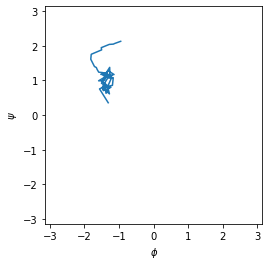

In [53]:
fig, axs = plt.subplots()

axs.plot(vals[:, 1], vals[:, 0])

axs.set_xlim(-np.pi, np.pi)
axs.set_ylim(-np.pi, np.pi)
axs.set_xlabel("$\phi$")
axs.set_ylabel("$\psi$")
axs.set_aspect("equal")